三つのモデルに精度に応じた重みを付けてブレンディング
DT、LightGBM、XGBoostを使用。

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

import collections

import lightgbm as lgb

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split

Duplicate key in file WindowsPath('C:/Users/GuestUser/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  IPAexGothic')


In [2]:
pd.set_option('display.max_rows', None)

データを変数に入れる

In [3]:
train = pd.read_table('train.tsv')
test = pd.read_csv('test.tsv',sep='\t')
sample = pd.read_csv('sample_submit.csv',header=None)

データを整える　※native-countryについて、trainかtest片方にしかないものは？に変換してしまう。

In [4]:
train = train.replace({"Y":{"<=50K" : 0, ">50K" : 1}})
train["Y"].value_counts()

0    12288
1     3992
Name: Y, dtype: int64

In [5]:
trainX = train.iloc[:,0:15]
y = train["Y"]
testX = test.copy()

In [6]:
train = train.drop(columns=["id","education"])
trainX = trainX.drop(columns=["id","education"])
testX = testX.drop(columns=["id","education"])

In [7]:
indexNum = testX[~testX["native-country"].isin(trainX["native-country"].unique())].index
for i in indexNum:
    testX.iat[i,12] = "?"
    print(testX.iat[i,12])

?


In [8]:
trainX = trainX.replace({"sex":{"Female" : 0, "Male" : 1}})
testX = testX.replace({"sex":{"Female" : 0, "Male" : 1}})

In [13]:
pd.reset_option('display.max_rows')

In [14]:
trainX = pd.get_dummies(trainX)
testX = pd.get_dummies(testX)

データ間の相関関係の強さを確認する

In [16]:
trainX1 = trainX.iloc[:,0:23]
trainX2 = trainX.iloc[:,23:49]
trainX3 = trainX.iloc[:,49:90]

<AxesSubplot:>

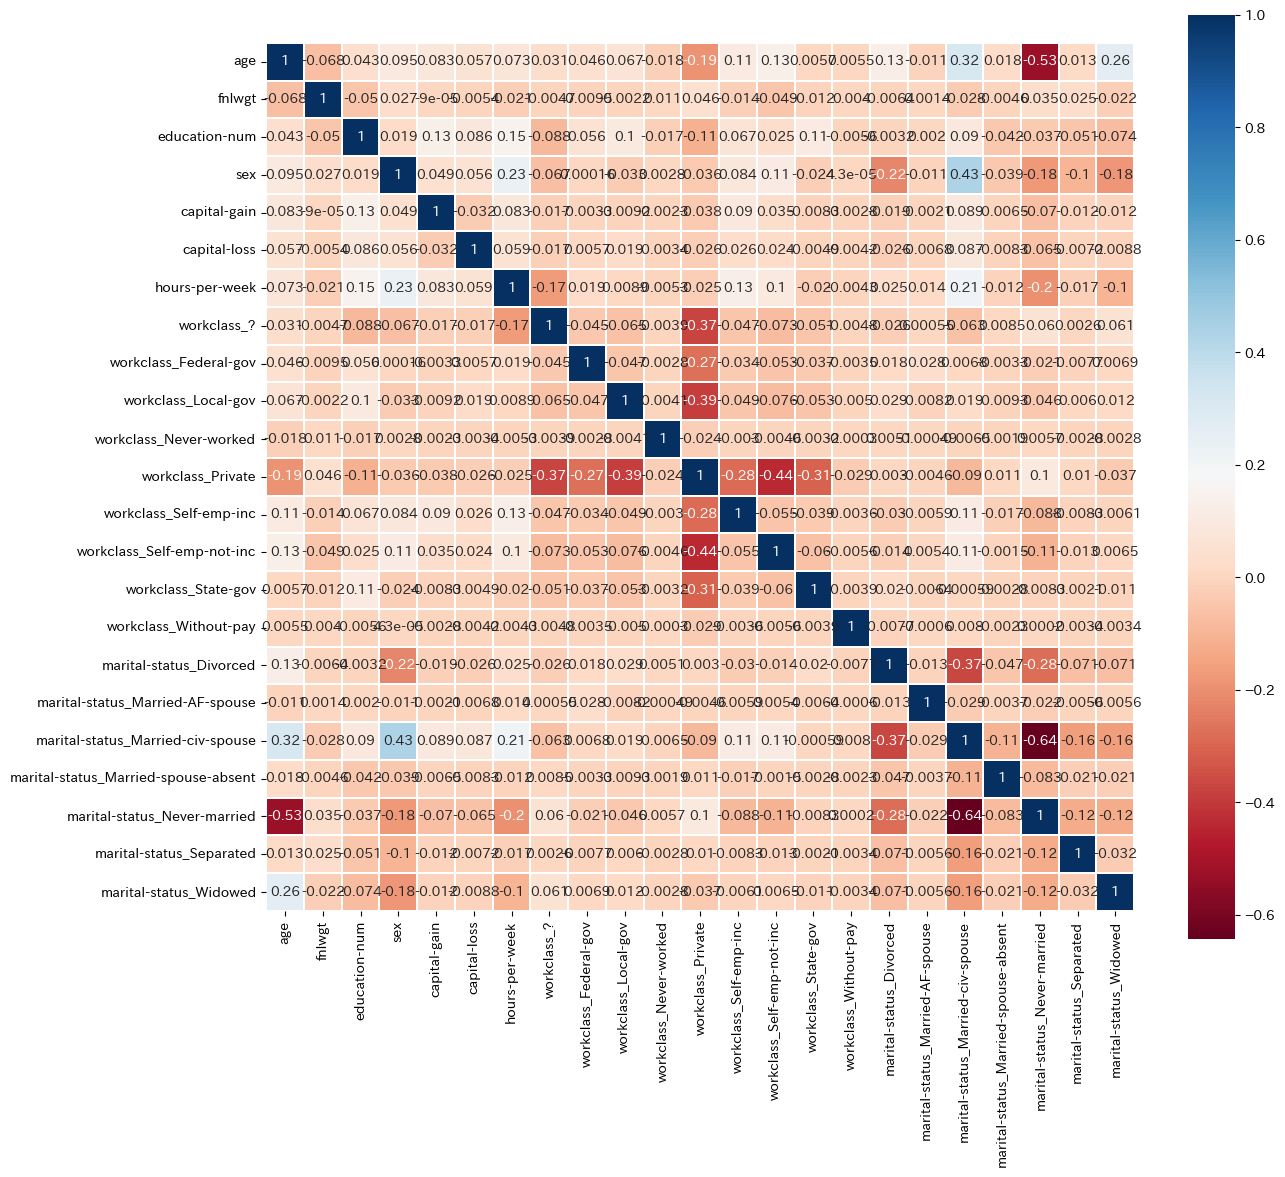

In [17]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
sns.heatmap(trainX1.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [142]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(trainX, y, test_size=0.2, random_state = 100)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state = 100)
print(trainX.shape, X_train.shape, X_valid.shape, X_test.shape)

(16280, 90) (10419, 90) (2605, 90) (3256, 90)


3モデルを作る

In [143]:
model_DT = DT()
model_LGB = lgb.LGBMClassifier(boosting_type='goss', max_depth=6, random_state=0)
model_XGB = XGBClassifier(early_stopping_rounds=15)

In [144]:
model_DT.fit(X_train, y_train)

eval_set = [(X_test, y_test)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
model_LGB.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

model_XGB.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[1]	valid_0's binary_logloss: 0.511795
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.481821
[3]	valid_0's binary_logloss: 0.458024
[4]	valid_0's binary_logloss: 0.438747
[5]	valid_0's binary_logloss: 0.422332
[6]	valid_0's binary_logloss: 0.408081
[7]	valid_0's binary_logloss: 0.395841
[8]	valid_0's binary_logloss: 0.385261
[9]	valid_0's binary_logloss: 0.37624
[10]	valid_0's binary_logloss: 0.368479
[11]	valid_0's binary_logloss: 0.361877
[12]	valid_0's binary_logloss: 0.3562
[13]	valid_0's binary_logloss: 0.351153
[14]	valid_0's binary_logloss: 0.346781
[15]	valid_0's binary_logloss: 0.342918
[16]	valid_0's binary_logloss: 0.339955
[17]	valid_0's binary_logloss: 0.33662
[18]	valid_0's binary_logloss: 0.333867
[19]	valid_0's binary_logloss: 0.330911
[20]	valid_0's binary_logloss: 0.32876
[21]	valid_0's binary_logloss: 0.326796
[22]	valid_0's binary_logloss: 0.325055
[23]	valid_0's binary_logloss: 0.323214
[24]	valid_0's binary_logloss: 0.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=15,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [145]:
test_pred_DT = model_DT.predict(X_test)
test_pred_LGB = model_LGB.predict(X_test)
test_pred_XGB = model_XGB.predict(X_test)

各モデルの精度を確認

In [146]:
from sklearn.metrics import mean_squared_error
print ("モデル1の平均2乗誤差: {:.4f}".format(mean_squared_error(y_test, test_pred_DT)))
print ("モデル2の平均2乗誤差: {:.4f}".format(mean_squared_error(y_test, test_pred_LGB)))
print ("モデル3の平均2乗誤差: {:.4f}".format(mean_squared_error(y_test, test_pred_XGB)))

モデル1の平均2乗誤差: 0.1791
モデル2の平均2乗誤差: 0.1422
モデル3の平均2乗誤差: 0.1382


XGB＞LGB＞DTの順で精度が高い

スタッキング（ブレンディング）

In [147]:
first_pred_DT = model_DT.predict(X_valid)
first_pred_LGB = model_LGB.predict(X_valid)
first_pred_XGB = model_XGB.predict(X_valid)

In [148]:
stack_pred = np.column_stack((first_pred_DT, first_pred_LGB, first_pred_XGB))
stack_pred

array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 1],
       ...,
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int64)

In [149]:
# 各モデルの検証データを積み重ねる
stack_test_pred = np.column_stack((test_pred_DT, test_pred_LGB, test_pred_XGB))

In [150]:
# メタモデルの学習 
meta_model1 = XGBClassifier(early_stopping_rounds=10)
eval_set2 = [(stack_test_pred, y_test)]
meta_model1.fit(stack_pred, y_valid, eval_set = eval_set2, verbose=True)

[0]	validation_0-logloss:0.54714
[1]	validation_0-logloss:0.47043
[2]	validation_0-logloss:0.42664
[3]	validation_0-logloss:0.40109
[4]	validation_0-logloss:0.38627
[5]	validation_0-logloss:0.37788
[6]	validation_0-logloss:0.37329
[7]	validation_0-logloss:0.37092
[8]	validation_0-logloss:0.36981
[9]	validation_0-logloss:0.36935
[10]	validation_0-logloss:0.36923
[11]	validation_0-logloss:0.36924
[12]	validation_0-logloss:0.36932
[13]	validation_0-logloss:0.36940
[14]	validation_0-logloss:0.36947
[15]	validation_0-logloss:0.36954
[16]	validation_0-logloss:0.36958
[17]	validation_0-logloss:0.36962
[18]	validation_0-logloss:0.36965
[19]	validation_0-logloss:0.36966


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [151]:
meta1_test_pred = meta_model1.predict(stack_test_pred)
print ("メタモデルの平均2乗誤差: {:.4f}".format(mean_squared_error(y_test, meta1_test_pred)))

メタモデルの平均2乗誤差: 0.1419


予測に代入して結果を出力する

In [152]:
production_pred_DT = model_DT.predict(testX)
production_pred_LGB = model_LGB.predict(testX)
production_pred_XGB = model_XGB.predict(testX)

In [153]:
stack_production_pred = np.column_stack((production_pred_DT, production_pred_LGB, production_pred_XGB))
pred = meta_model1.predict(stack_production_pred)
pred_r = pd.DataFrame(data=pred, index=None, columns=None)
pred_r.value_counts()

0    13046
1     3235
dtype: int64

In [154]:
pred_r = pred_r.replace({0:{0 : "<=50K", 1 : ">50K"}})

In [155]:
sample[1] = pred_r

In [156]:
sample.to_csv("submit7_7.csv",index=None,header=None)